In [3]:
import pathlib
import numpy as np  
import pandas as pd

import sys
sys.path.append("../unilasso")

In [4]:
import pathlib
import pandas as pd

def read_data(folder: pathlib.Path):
    """Return dictionary of each cohort as a dataframe.

    Args:
        folder (pathlib.Path): Path to the folder containing the data.

    Returns:
        dict[str, pd.DataFrame]: Dictionary containing the dataframes for each cohort.
    """
    df = pd.read_csv(folder / "All_datasets_SomaScan_Plasma_7k_CVQC_SADRC_KADRC_ROSMAP_Kaci.csv")
    return {
        cohort: table for cohort, table in df.groupby("Cohort")
    }

def format_for_regression(df: pd.DataFrame, target_variable: str = "Age"):
    """Returns in X, y format for regression

    Args:
        df (pd.DataFrame): DataFrame with the data
        target_variable (str, optional): Target variable to use. Defaults to "Age".

    Returns:
        (pd.DataFrame, pd.DataFrame): X, y dataframes.
    """
    return df.iloc[:, 31:], df[target_variable]

In [ ]:
folder = pathlib.Path("/Users/jameshaberberger/Gitlab/proteonn/data")
datasets = read_data(folder)

for k, output in datasets.items():
    print(k, output.shape[0])

In [ ]:
X, y = format_for_regression(datasets["KADRC"])

# Ensemble of Isotonic Regressions

In [11]:
import numpy as np
import sklearn.isotonic
from tqdm.notebook import tqdm

# Precompute isotonic regressions
regressors = {
    i: sklearn.isotonic.IsotonicRegression(increasing=False, out_of_bounds="clip").fit(X.iloc[:, i], y)
    for i in tqdm(range(X.shape[1]))
}

# Precompute predictions for efficiency
predictions_matrix = np.column_stack([
    regressors[i].predict(X.iloc[:, i]) for i in range(X.shape[1])
])

  0%|          | 0/7040 [00:00<?, ?it/s]

In [16]:
## ORIGINAL Prior to reading their paper, just used nnls.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

from scipy.optimize import nnls

def optimize_nnls_weights(X_preds, y):
    """
    Optimize non-negative weights using NNLS.
    """
    weights, _ = nnls(X_preds, y, maxiter=1_000_000)
    return weights


# Example usage
weights = optimize_nnls_weights(predictions_matrix, y)
y_pred = np.dot(predictions_matrix, weights)


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV

def optimize_lasso_cv_weights(X_preds, y, cv=5):
    """
    Optimize weights using Lasso regression with cross-validation.
    
    Parameters:
        X_preds : ndarray of shape (n_samples, n_models)
            Matrix of predictions from base models.
        y : ndarray of shape (n_samples,)
            True target values.
        cv : int
            Number of cross-validation folds.
    
    Returns:
        weights : ndarray of shape (n_models,)
            Optimized Lasso weights.
    """
    model = LassoCV(cv=cv, fit_intercept=False, max_iter=1000, n_jobs=-1)
    model.fit(X_preds, y)
    return model.coef_, model.alpha_

# Example usage
weights, best_alpha = optimize_lasso_cv_weights(predictions_matrix, y)
y_pred = np.dot(predictions_matrix, weights)

/Users/jameshaberberger/GitHub/unilasso/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.355e+04, tolerance: 1.766e+03
  model = cd_fast.enet_coordinate_descent(


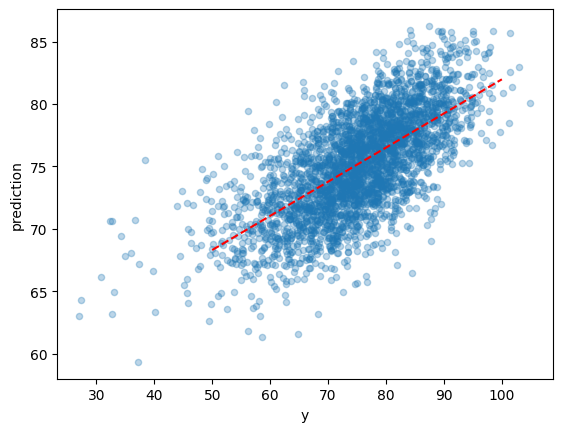

In [21]:
from sklearn.linear_model import LinearRegression

pd.DataFrame({
    "y": y,
    "prediction": y_pred
}).plot.scatter(x="y", y="prediction", alpha=0.3)

# Fit a linear regression model
model = LinearRegression()
model.fit(
    y.to_numpy().reshape(-1, 1),
    y_pred
)

plt.plot(
    [50, 100], 
    [50 * model.coef_[0] + model.intercept_, 100 * model.coef_[0] + model.intercept_],
    color="red",
    linestyle="--"
)

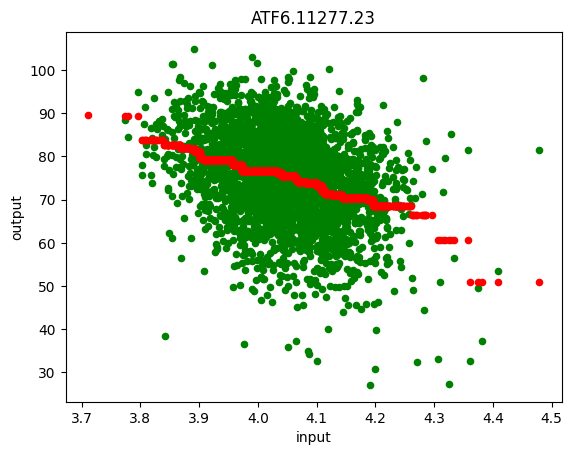

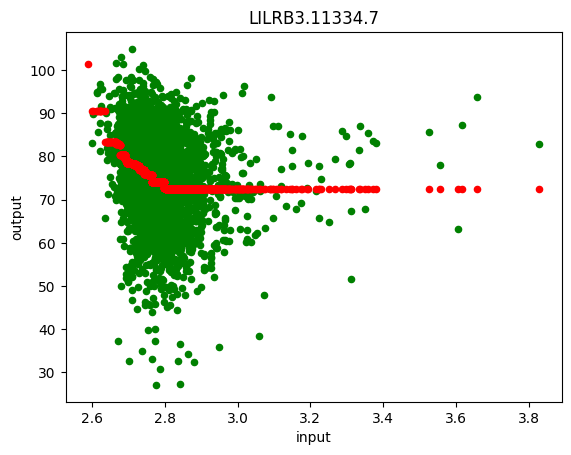

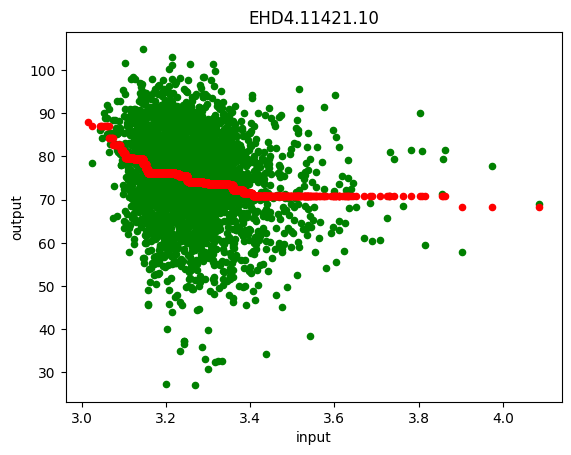

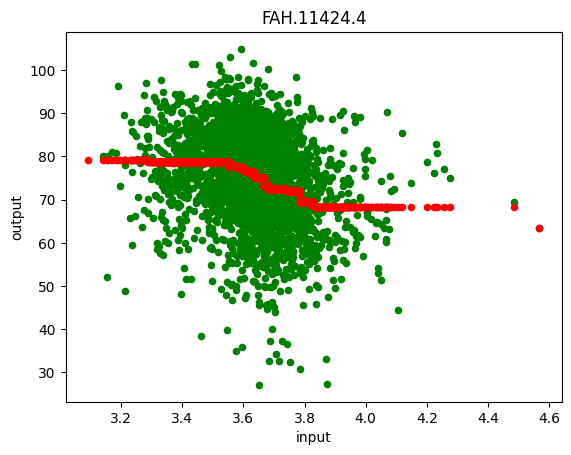

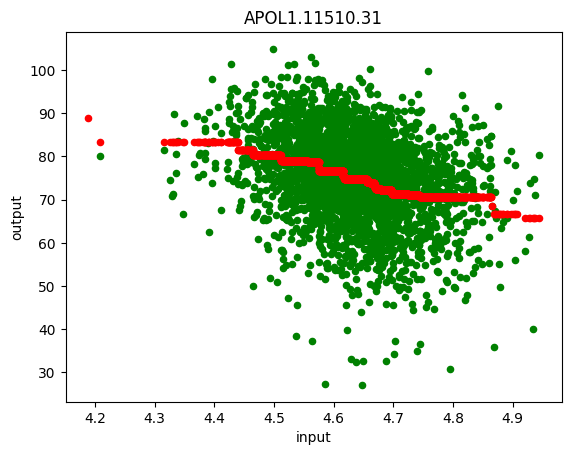

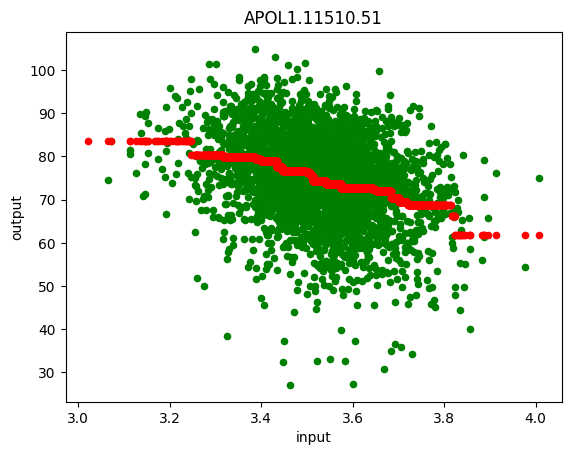

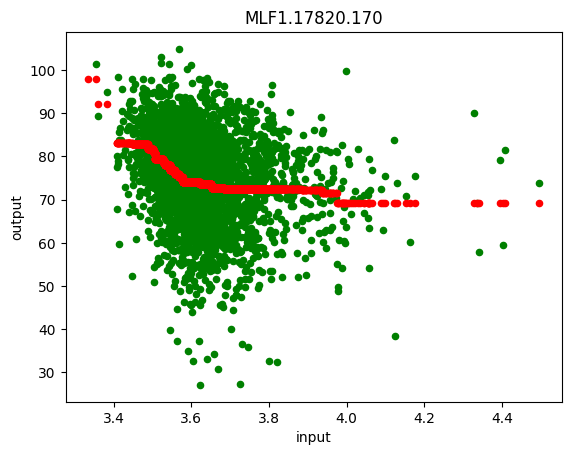

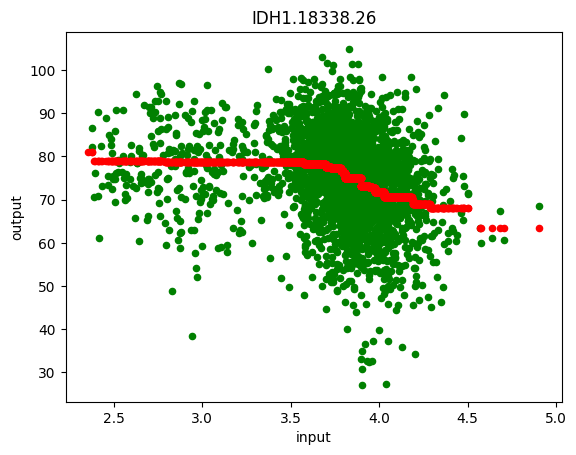

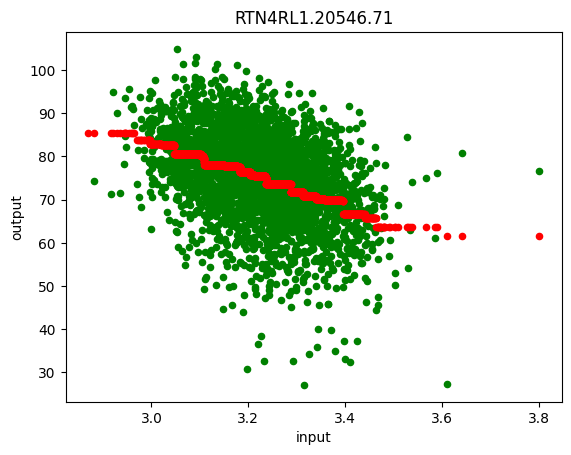

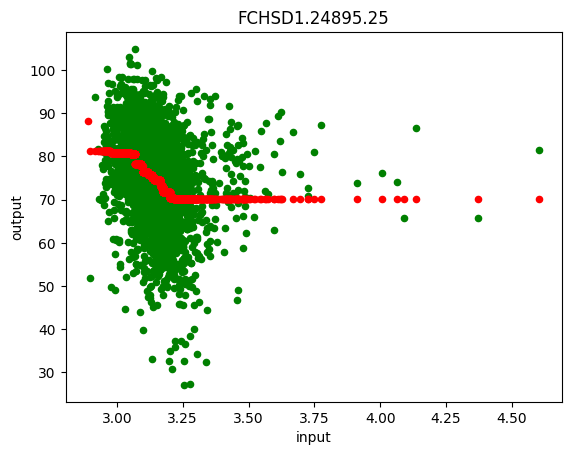

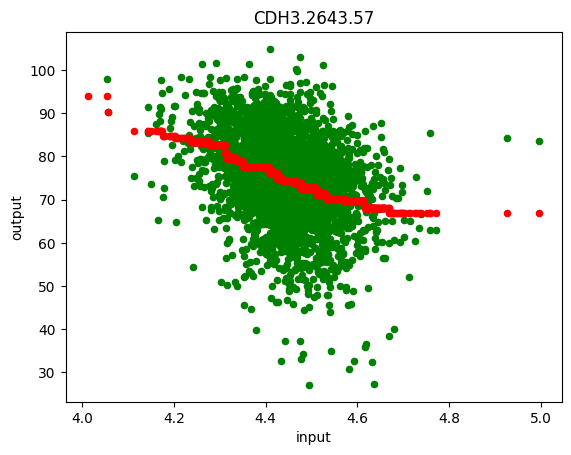

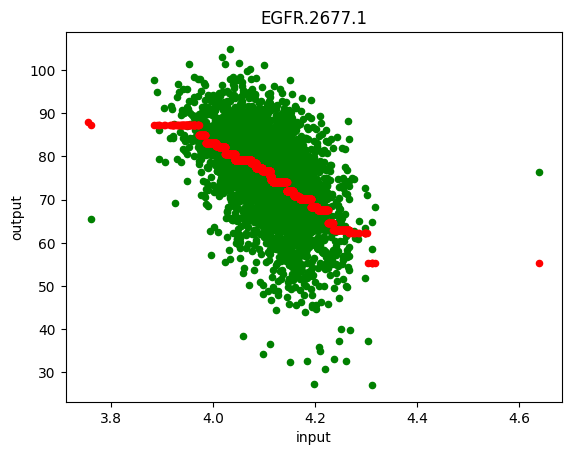

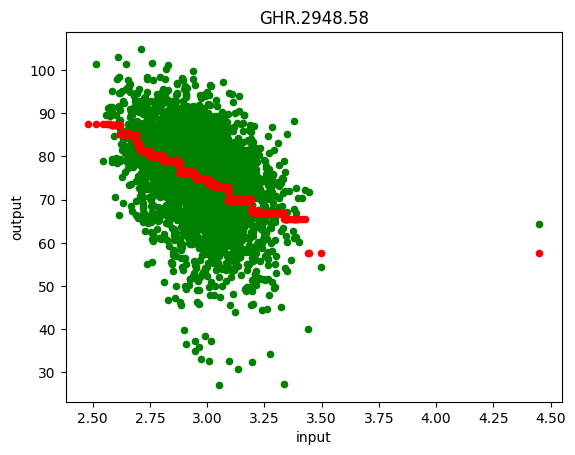

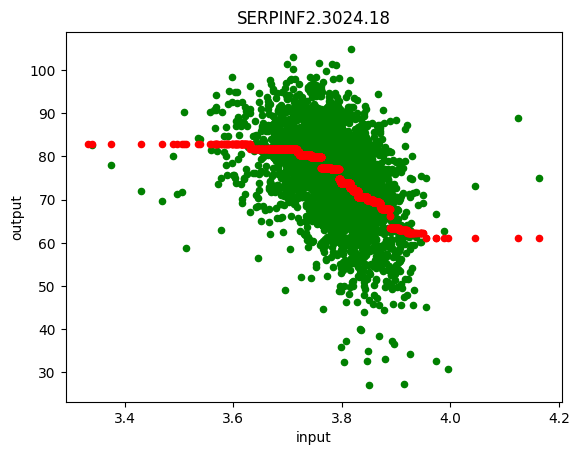

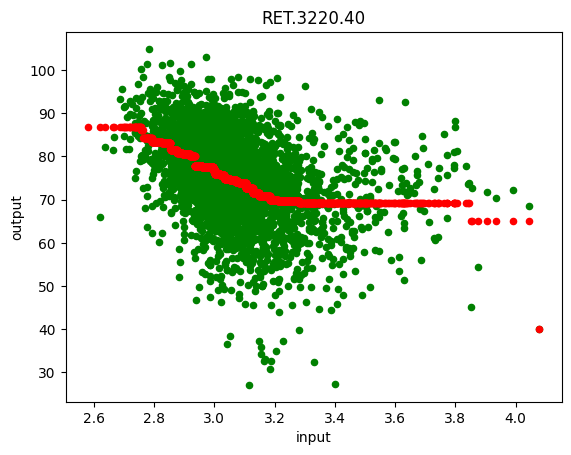

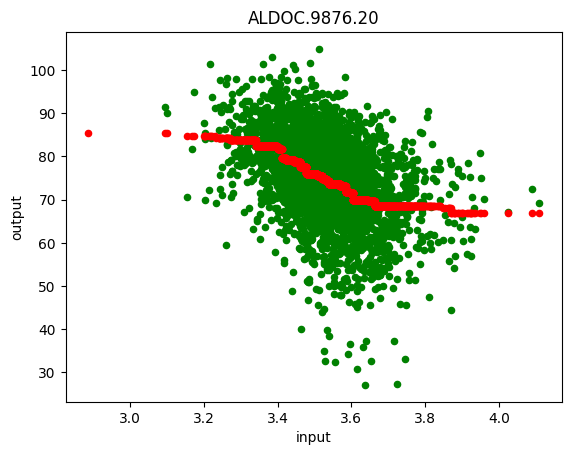

In [22]:
import matplotlib.pyplot as plt

for covariate, weight in pd.Series(weights, index=X.columns)[pd.Series(weights, index=X.columns) > 0].to_dict().items():
    regressor_index = np.where(X.columns == covariate)[0][0]

    remove_me = pd.DataFrame({
        "input": X.iloc[:, regressor_index],
        "output": y,
    })["input"].idxmin()

    ax = pd.DataFrame({
        "input": X.iloc[:, regressor_index],
        "output": y,
    }).drop(remove_me).plot.scatter(x="input", y="output", c="g")
    pd.DataFrame({
        "input": X.iloc[:, regressor_index],
        "output": regressors[regressor_index].predict(X.iloc[:, regressor_index]),
    }).plot.scatter(x="input", y="output", c="r", ax = ax)
    plt.title(covariate)

# Test Dataset

In [23]:
X, y = data.format_for_regression(datasets["SADRC"])

y_pred = np.zeros_like(y)
for covariate, weight in pd.Series(weights, index=X.columns)[pd.Series(weights, index=X.columns) > 0].to_dict().items():
    y_pred += weight * regressors[np.where(X.columns == covariate)[0][0]].predict(X[covariate])

<Axes: xlabel='y', ylabel='prediction'>

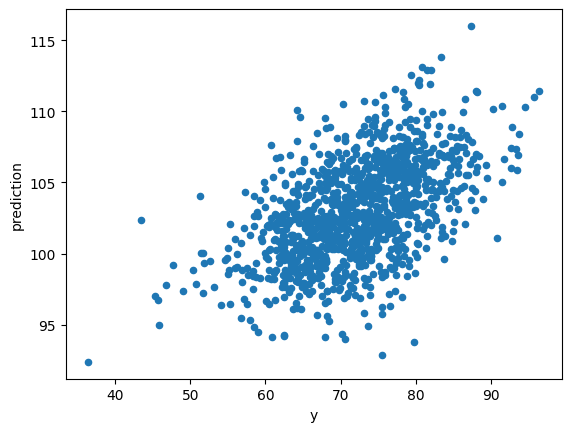

In [24]:
pd.DataFrame({
    "y": y,
    "prediction": y_pred
}).dropna().plot.scatter(x="y", y="prediction")

# Evaluation of Fit

In [25]:
pd.Series(weights, index=X.columns)[pd.Series(weights, index=X.columns) > 0].sort_values(ascending=False)

EGFR.2677.1         0.443648
SERPINF2.3024.18    0.291699
RTN4RL1.20546.71    0.204889
APOL1.11510.31      0.132088
FCHSD1.24895.25     0.078114
RET.3220.40         0.050939
ALDOC.9876.20       0.032774
APOL1.11510.51      0.029151
IDH1.18338.26       0.025690
CDH3.2643.57        0.021455
ATF6.11277.23       0.020910
EHD4.11421.10       0.014446
FAH.11424.4         0.009369
MLF1.17820.170      0.007100
GHR.2948.58         0.006177
LILRB3.11334.7      0.002631
dtype: float64

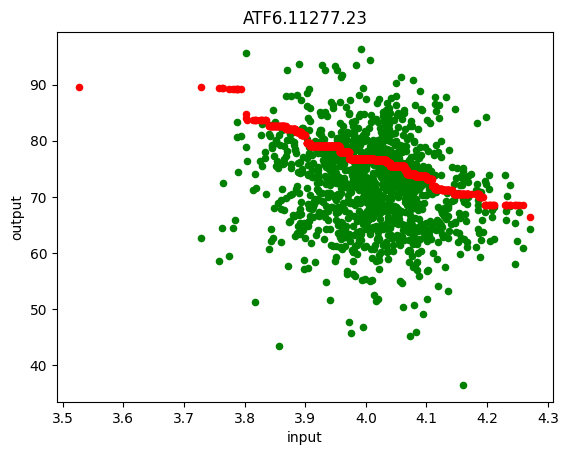

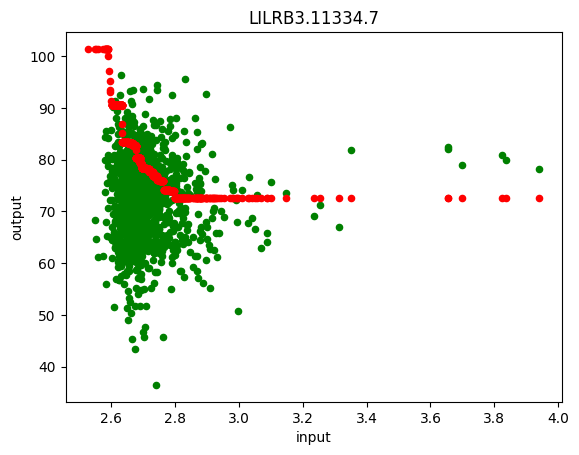

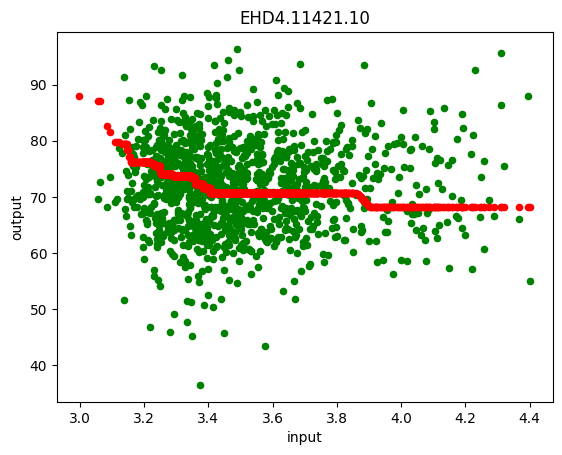

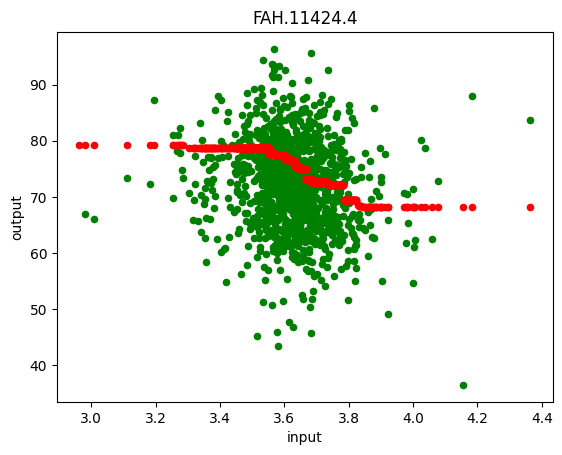

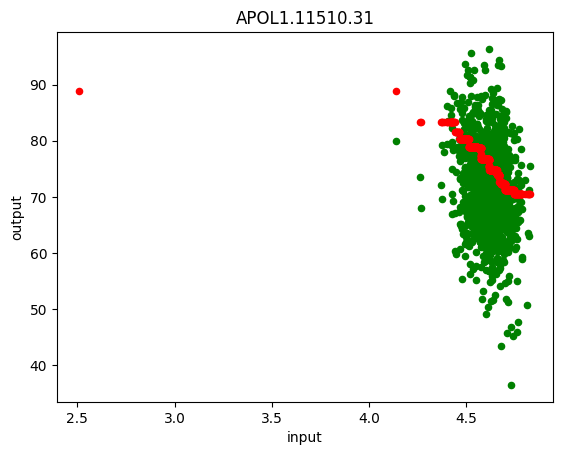

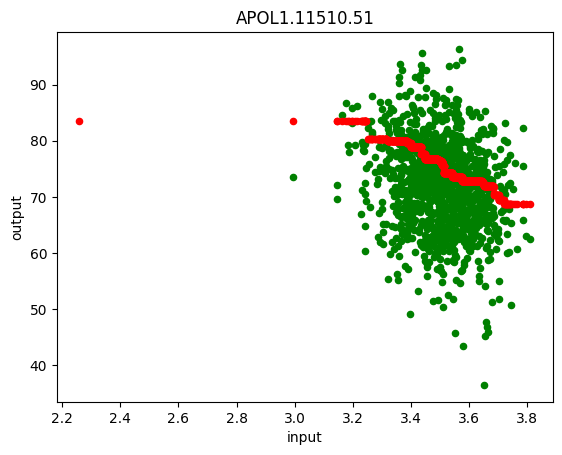

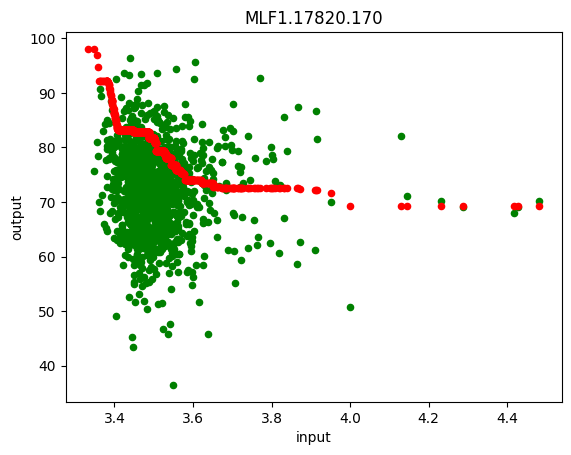

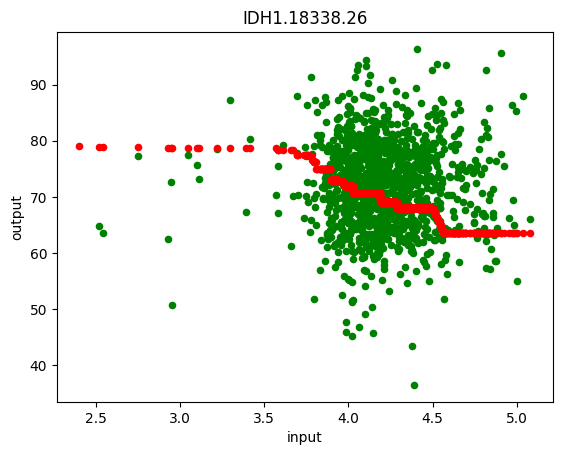

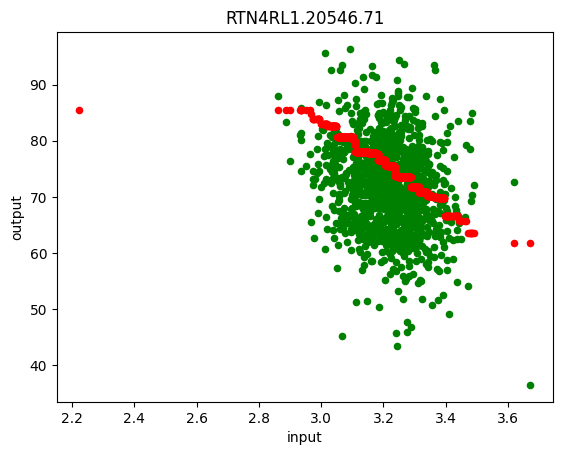

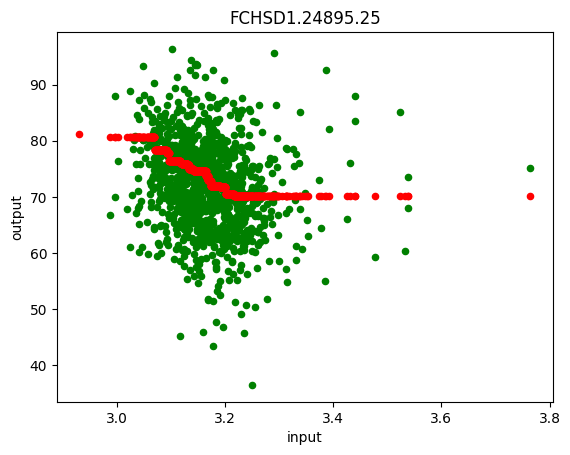

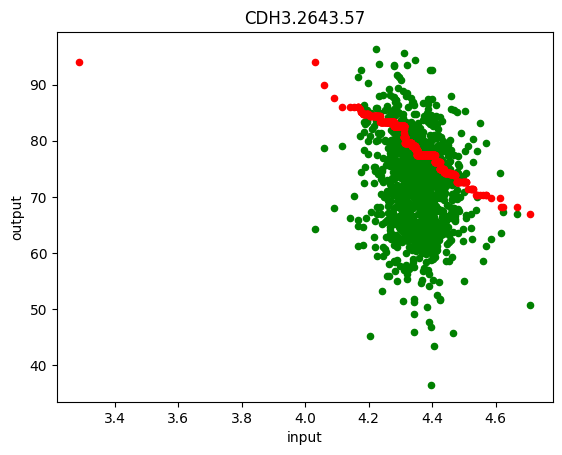

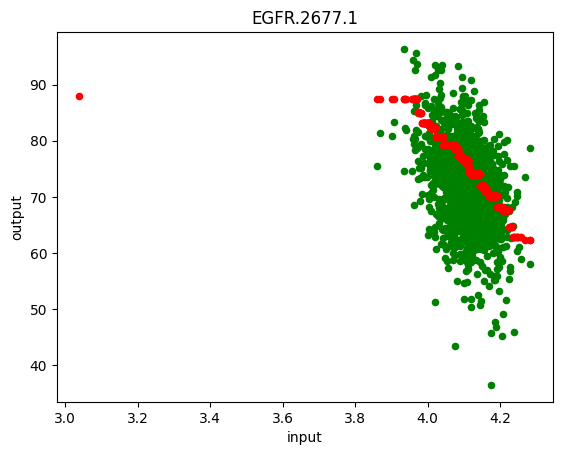

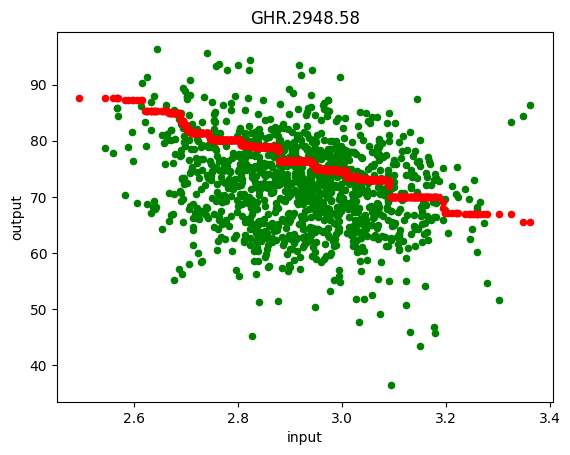

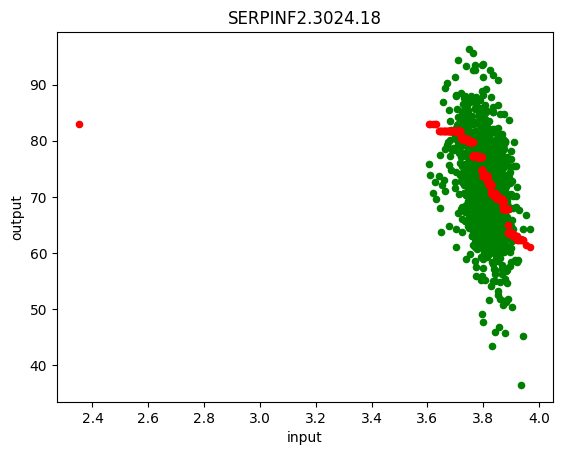

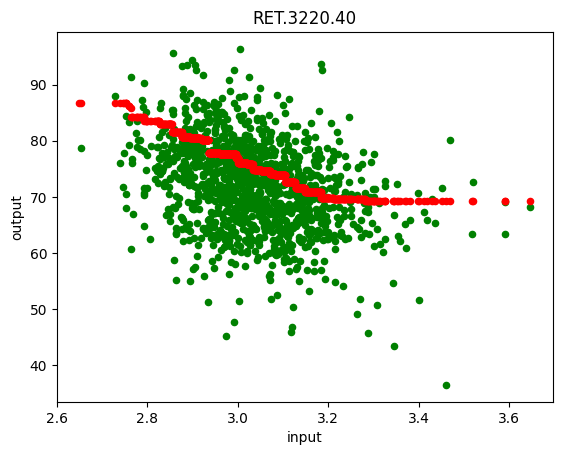

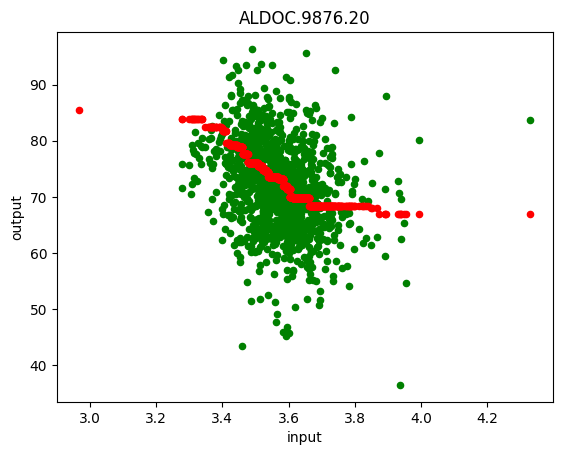

In [27]:
import matplotlib.pyplot as plt

for covariate, weight in pd.Series(weights, index=X.columns)[pd.Series(weights, index=X.columns) > 0].to_dict().items():
    regressor_index = np.where(X.columns == covariate)[0][0]

    remove_me = pd.DataFrame({
        "input": X.iloc[:, regressor_index],
        "output": y,
    })["input"].idxmin()

    ax = pd.DataFrame({
        "input": X.iloc[:, regressor_index],
        "output": y,
    }).drop(remove_me).plot.scatter(x="input", y="output", c="g")
    pd.DataFrame({
        "input": X.iloc[:, regressor_index],
        "output": regressors[regressor_index].predict(X.iloc[:, regressor_index]),
    }).plot.scatter(x="input", y="output", c="r", ax = ax)
    plt.title(covariate)

# Sequential Isotonic Regression 
Just for fun.

In [29]:
X, y = data.format_for_regression(datasets["KADRC"])

pipeline = []
residuals = y

while len(pipeline) < 20:

    regressors = {
        i: sklearn.isotonic.IsotonicRegression(increasing=False, out_of_bounds="clip").fit(X.iloc[:, i], residuals)
        for i in tqdm(range(X.shape[1]))
    }

    best_performing = pd.Series({i: regressors[i].score(X.iloc[:, i], residuals) for i in tqdm(range(X.shape[1]))}).sort_values(ascending=False).index[0]

    pipeline.append((best_performing, regressors[best_performing]))

    residuals = residuals - regressors[best_performing].predict(X.iloc[:, best_performing])


  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

  0%|          | 0/7040 [00:00<?, ?it/s]

In [30]:
np.abs(np.array([regressor.predict(X.iloc[:, i]) for i, regressor in pipeline])).mean(axis=1)

array([75.08896585,  2.79842389,  1.97781742,  1.60820655,  1.43666545,
        1.13828296,  1.09827069,  1.06250996,  0.73192865,  0.76290044,
        0.79653619,  0.83419618,  0.82436351,  0.6491034 ,  0.71911186,
        0.36588838,  0.64083306,  0.50547576,  0.53199063,  0.58461399])

<Axes: xlabel='y', ylabel='prediction'>

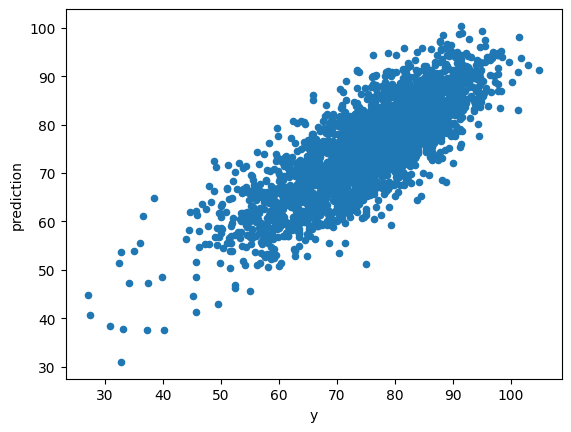

In [31]:
pd.DataFrame({
    "prediction": np.array([regressor.predict(X.iloc[:, i]) for i, regressor in pipeline]).sum(axis=0),
    "y": y
}).plot.scatter(x="y", y="prediction")

<Axes: xlabel='y', ylabel='prediction'>

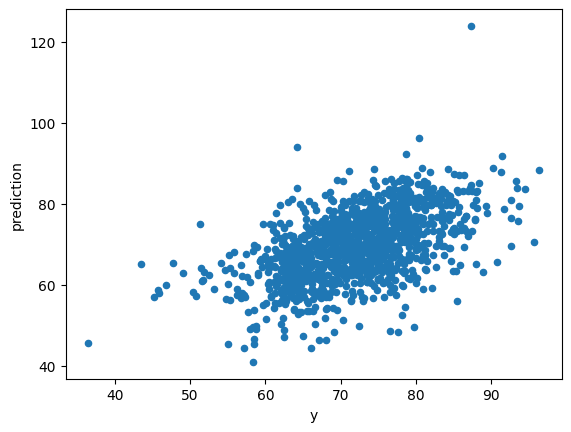

In [32]:
X, y = data.format_for_regression(datasets["SADRC"])

pd.DataFrame({
    "prediction": np.array([regressor.predict(X.iloc[:, i]) for i, regressor in pipeline]).sum(axis=0),
    "y": y
}).plot.scatter(x="y", y="prediction")